In [1]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [2]:
#Load datasets
train_data = torch.load("localization_train.pt")
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

validation_data = torch.load("localization_val.pt")
validation_loader = DataLoader(validation_data, batch_size=64, shuffle=False)

test_data = torch.load("localization_test.pt")
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)


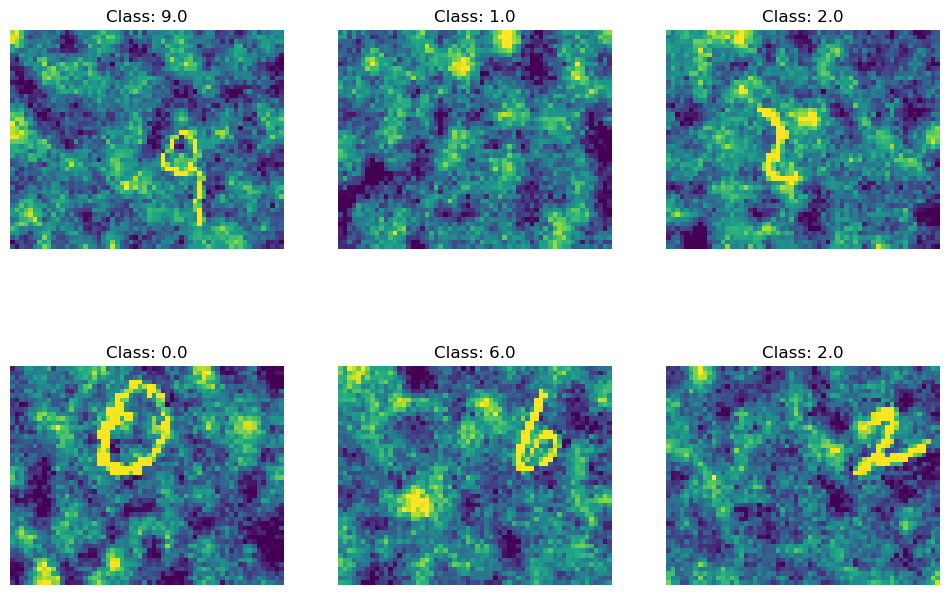

Total number of training images: 59400
Total number of classes: 10


In [3]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
for i in range(2):
    for j in range(3):
        image, labels = next(iter(train_loader))
        axs[i, j].imshow(image[0].permute(1, 2, 0))
        axs[i, j].axis('off')
        axs[i, j].set_title(f"Class: {labels[0][5].item()}")
plt.show()

# Dataset information
total_images = len(train_data)
total_classes = len(set([labels[i][5].item() for _, labels in train_loader]))  # Se asume que la clase está en la posición 5 del tensor de etiquetas

print(f"Total number of training images: {total_images}")
print(f"Total number of classes: {total_classes}")

In [4]:
# First model (basic one)

class CNNModel1(nn.Module):
    def __init__(self):
        super(CNNModel1, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 12 * 15, 120)
        self.fc2 = nn.Linear(120, 15)
    
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 32 * 12 * 15)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [5]:
# Second model (intermediate one)

class CNNModel2(nn.Module):
    def __init__(self):
        super(CNNModel2, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)  # Capa adicional
        self.bn3 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 6 * 7, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 15)
    
    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))  # Procesamiento de la capa adicional
        x = x.view(-1, 256 * 6 * 7)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [6]:
# Third model (advanced one)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class CNNModel3(nn.Module):
    def __init__(self):
        super(CNNModel3, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layer1 = ResidualBlock(32, 64, stride=2)
        self.layer2 = ResidualBlock(64, 128, stride=2)
        self.layer3 = ResidualBlock(128, 256, stride=2)
        self.fc1 = nn.Linear(256 * 6 * 7, 1024)  #Dimensional adjustment after the convolutional layers
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, 15)
    
    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = F.adaptive_avg_pool2d(x, (6, 7))
        x = x.view(-1, 256 * 6 * 7)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x



In [7]:
# Loss function

class ObjectLocalizationLoss(nn.Module):
    def __init__(self):
        super(ObjectLocalizationLoss, self).__init__()
        self.bce_loss = nn.BCEWithLogitsLoss(reduction='none')
        self.mse_loss = nn.MSELoss(reduction='none')
        self.ce_loss = nn.CrossEntropyLoss()

    def forward(self, y_pred, y_true):
        # Prediction labels
        pc_pred = y_pred[:, 0]
        bb_pred = y_pred[:, 1:5]
        class_pred = y_pred[:, 5:]

        # True labels
        pc_true = y_true[:, 0]
        bb_true = y_true[:, 1:5]
        class_true = y_true[:, 5].long()

        # Detection loss
        loss_detection = self.bce_loss(pc_pred, pc_true)
        # Localization loss
        loss_localization = torch.sum(self.mse_loss(bb_pred, bb_true), dim=1)
        # Classification loss
        loss_classification = self.ce_loss(class_pred, class_true)

        # Total loss
        loss = pc_true * (loss_detection + loss_localization.unsqueeze(1) + loss_classification) + \
               (1 - pc_true) * loss_detection

        return loss.mean()


In [8]:
# Training function

def train_model(model, train_loader, num_epochs=10, lr=0.001):
    # Define the loss function and optimizer
    criterion = ObjectLocalizationLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_losses = []

    # Training
    print(f"Training {model.__class__.__name__}")
    for epoch in range(num_epochs):

        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    print(f"Training of {model.__class__.__name__} completed.")
    return train_losses


In [114]:
model1 = CNNModel1()

train_losses1 = train_model(model1, train_loader, num_epochs=100, lr=0.001)

Training CNNModel1
Epoch [1/100], Loss: 2.1269
Epoch [2/100], Loss: 1.7312
Epoch [3/100], Loss: 1.5024
Epoch [4/100], Loss: 1.3335
Epoch [5/100], Loss: 1.1370
Epoch [6/100], Loss: 0.9602
Epoch [7/100], Loss: 0.8248
Epoch [8/100], Loss: 0.7224
Epoch [9/100], Loss: 0.6363
Epoch [10/100], Loss: 0.5720
Epoch [11/100], Loss: 0.5173
Epoch [12/100], Loss: 0.4710
Epoch [13/100], Loss: 0.4267
Epoch [14/100], Loss: 0.3879
Epoch [15/100], Loss: 0.3533
Epoch [16/100], Loss: 0.3182
Epoch [17/100], Loss: 0.2920
Epoch [18/100], Loss: 0.2663
Epoch [19/100], Loss: 0.2420
Epoch [20/100], Loss: 0.2202
Epoch [21/100], Loss: 0.1990
Epoch [22/100], Loss: 0.1792
Epoch [23/100], Loss: 0.1639
Epoch [24/100], Loss: 0.1452
Epoch [25/100], Loss: 0.1316
Epoch [26/100], Loss: 0.1171
Epoch [27/100], Loss: 0.1034
Epoch [28/100], Loss: 0.0969
Epoch [29/100], Loss: 0.0824
Epoch [30/100], Loss: 0.0801
Epoch [31/100], Loss: 0.0732
Epoch [32/100], Loss: 0.0663
Epoch [33/100], Loss: 0.0632
Epoch [34/100], Loss: 0.0595
Epoc

In [115]:
model2 = CNNModel2()

train_losses2 = train_model(model2, train_loader, num_epochs=100, lr=0.001)

Training CNNModel2
Epoch [1/100], Loss: 4.5989
Epoch [2/100], Loss: 1.9778
Epoch [3/100], Loss: 1.8084
Epoch [4/100], Loss: 1.6758
Epoch [5/100], Loss: 1.5127
Epoch [6/100], Loss: 1.3931
Epoch [7/100], Loss: 1.2776
Epoch [8/100], Loss: 1.1267
Epoch [9/100], Loss: 1.0054
Epoch [10/100], Loss: 0.9081
Epoch [11/100], Loss: 0.7846
Epoch [12/100], Loss: 0.6965
Epoch [13/100], Loss: 0.6146
Epoch [14/100], Loss: 0.5465
Epoch [15/100], Loss: 0.5029
Epoch [16/100], Loss: 0.4670
Epoch [17/100], Loss: 0.4352
Epoch [18/100], Loss: 0.4116
Epoch [19/100], Loss: 0.3881
Epoch [20/100], Loss: 0.3707
Epoch [21/100], Loss: 0.3469
Epoch [22/100], Loss: 0.3324
Epoch [23/100], Loss: 0.3115
Epoch [24/100], Loss: 0.3054
Epoch [25/100], Loss: 0.2914
Epoch [26/100], Loss: 0.2846
Epoch [27/100], Loss: 0.2636
Epoch [28/100], Loss: 0.2495
Epoch [29/100], Loss: 0.2363
Epoch [30/100], Loss: 0.2202
Epoch [31/100], Loss: 0.2103
Epoch [32/100], Loss: 0.1917
Epoch [33/100], Loss: 0.1899
Epoch [34/100], Loss: 0.1896
Epoc

In [11]:
model3 = CNNModel3()

rain_losses3 = train_model(model3, train_loader, num_epochs=50, lr=0.001)

Training CNNModel3
Epoch [1/50], Loss: 4.0547
Epoch [2/50], Loss: 1.7764
Epoch [3/50], Loss: 1.2885
Epoch [4/50], Loss: 0.8698
Epoch [5/50], Loss: 0.6698
Epoch [6/50], Loss: 0.5851
Epoch [7/50], Loss: 0.5193
Epoch [8/50], Loss: 0.4607
Epoch [9/50], Loss: 0.3887
Epoch [10/50], Loss: 0.3154
Epoch [11/50], Loss: 0.2790
Epoch [12/50], Loss: 0.2413
Epoch [13/50], Loss: 0.2197
Epoch [14/50], Loss: 0.2050
Epoch [15/50], Loss: 0.1896
Epoch [16/50], Loss: 0.1745
Epoch [17/50], Loss: 0.1653
Epoch [18/50], Loss: 0.1617
Epoch [19/50], Loss: 0.1407
Epoch [20/50], Loss: 0.1415
Epoch [21/50], Loss: 0.1313
Epoch [22/50], Loss: 0.1196
Epoch [23/50], Loss: 0.1162
Epoch [24/50], Loss: 0.1080
Epoch [25/50], Loss: 0.1079
Epoch [26/50], Loss: 0.1082
Epoch [27/50], Loss: 0.0960
Epoch [28/50], Loss: 0.0946
Epoch [29/50], Loss: 0.0932
Epoch [30/50], Loss: 0.0878
Epoch [31/50], Loss: 0.0884
Epoch [32/50], Loss: 0.0872
Epoch [33/50], Loss: 0.0811
Epoch [34/50], Loss: 0.0861
Epoch [35/50], Loss: 0.0776
Epoch [36/

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# IoU calculation
def calculate_iou(box1, box2):

    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    intersection_area = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)
    
    box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)
    union_area = box1_area + box2_area - intersection_area
    
    iou = intersection_area / union_area
    return iou

# Model evaluation
def evaluate_model(model, data_loader):
    model.eval()
    total_images = 0
    correct_detection = 0
    total_iou = 0.0
    
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            

            for i in range(len(labels)):
                total_images += 1
                if labels[i][0] == 1: 
                    if torch.sigmoid(outputs[i][0]) > 0.5:
                        if torch.argmax(outputs[i][5:]) == labels[i][5:]:
                            correct_detection += 1
                        true_box = labels[i][1:5].cpu().numpy()
                        pred_box = outputs[i][1:5].cpu().numpy()
                        iou = calculate_iou(true_box, pred_box)
                        total_iou += iou
                else:
                    if torch.sigmoid(outputs[i][0]) <= 0.5:
                        correct_detection += 1
    
    accuracy = correct_detection / total_images if total_images > 0 else 0
    mean_iou = total_iou / total_images if total_images > 0 else 0
    return accuracy, mean_iou



In [16]:
model3_accuracy, model3_iou = evaluate_model(model3, validation_loader)

print(f"Precision: {model3_accuracy}, IoU mean: {model3_iou}, total_mean: {(model3_accuracy + model3_iou) / 2}")

Precision: 0.9593939393939394, IoU mean: 0.7331171931258049, total_mean: 0.8462555662598721


In [20]:
# Evaluar el mejor modelo con los datos de prueba
best_model_accuracy, best_model_iou = evaluate_model(model3, test_loader)

best_model = model3
# Imprimir los resultados
print("Best model:")
print(f"Test accuracy: {best_model_accuracy}, IoU accucacy: {best_model_iou}, total_mean: {(best_model_accuracy + best_model_iou) / 2}")


Best model:
Test accuracy: 0.9645454545454546, IoU accucacy: 0.7322339910963881, total_mean: 0.8483897228209214


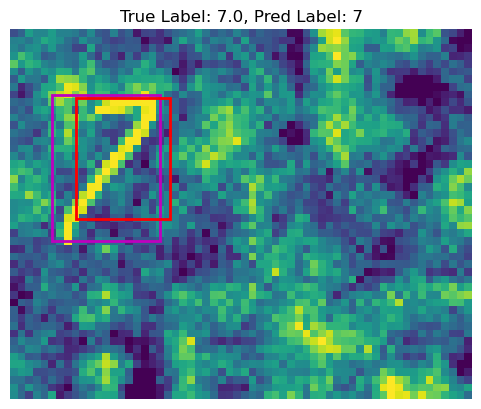

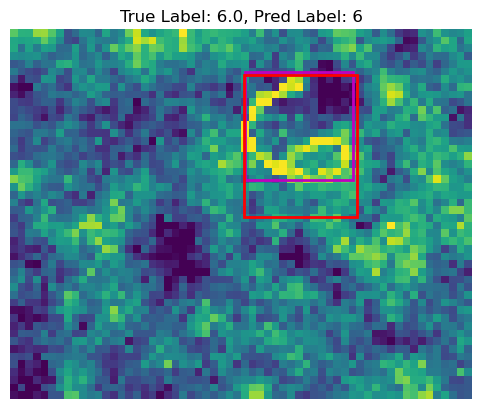

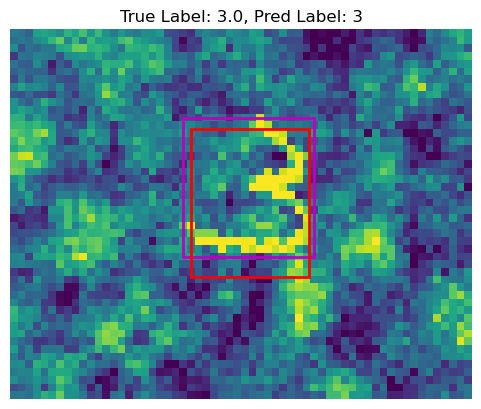

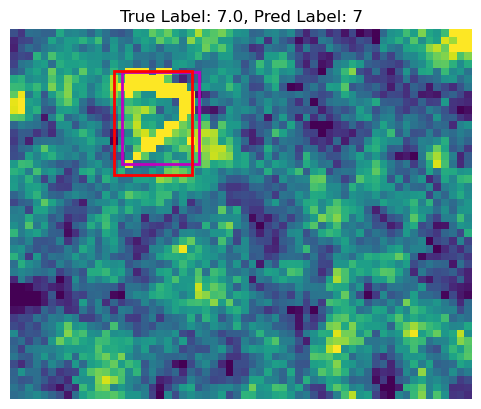

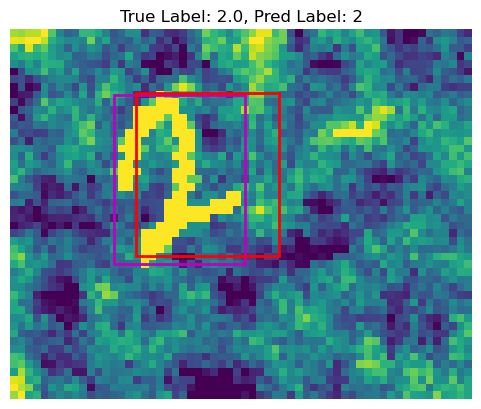

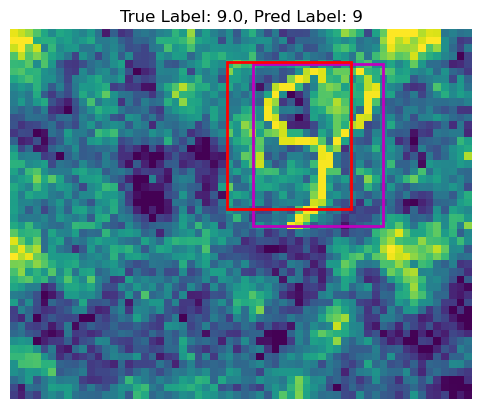

In [21]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_bounding_boxes(image, true_box, pred_box, true_label, pred_label):

    plt.imshow(image.permute(1, 2, 0))  
    
    width, height = image.size(2), image.size(1)
    
    def calcular_esquina(x, y, w, h, width, height):
        x_esquina = (x - w / 2) * width
        y_esquina = (y - h / 2) * height
        w_abs = w * width
        h_abs = h * height
        return x_esquina, y_esquina, w_abs, h_abs
    
    true_x, true_y, true_w, true_h = calcular_esquina(*true_box, width, height)
    true_rect = patches.Rectangle((true_x, true_y), true_w, true_h, linewidth=2, edgecolor='m', facecolor='none')
    plt.gca().add_patch(true_rect)
    
    pred_x, pred_y, pred_w, pred_h = calcular_esquina(*pred_box, width, height)
    pred_rect = patches.Rectangle((pred_x, pred_y), pred_w, pred_h, linewidth=2, edgecolor='r', facecolor='none')
    plt.gca().add_patch(pred_rect)
    
    plt.title(f"True Label: {true_label}, Pred Label: {pred_label}")
    plt.axis('off')
    plt.show()


sample_images, sample_labels = next(iter(validation_loader))

best_model.eval()
with torch.no_grad():
    pred_labels = best_model(sample_images.to(device))

for i in range(10, 16):
    image = sample_images[i]
    true_box = sample_labels[i][1:5].cpu().numpy()
    pred_box = pred_labels[i][1:5].cpu().numpy()
    true_label = sample_labels[i][5].item()
    pred_label = torch.argmax(pred_labels[i][5:]).item()
    draw_bounding_boxes(image, true_box, pred_box, true_label, pred_label)
